# Ethereum value prediction with Twitter analysis and Google Trends
## Summary
* Context
* Data Collection
* Data Preprocessing
* Model Construction
* Sanity check
* Model Training
* Evaluation

## Context
This project is done as an assignment for a course named "Python for finance".
We will try to get a regression model to predict the value of the Ethereum coin in dollars.
For that, we will gather data based on the relative interest people have for the subject on Google, we will also try to get a feeling of how are people actually reacting to ethereum with a sentiment analysis, based on the most retweeted tweets daily.

## Data Collection
As no dataset was available for what we were trying to do, we decided to scrape the data online. Between all data sources, the most that we could get was up to 3 years of data, we will therefore do our analysis with data from 14-01-2018 up to 01-01-2021 as it is the biggest usable range we could get.

In [125]:
import requests
import pandas as pd
import json
import numpy as np
import math
import re
from matplotlib import pyplot as plt
from pytrends.request import TrendReq
from datetime import datetime, date, timedelta

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import twint
from textblob import TextBlob

np.random.seed(0)

freeKey = "hidden****************"
# Get grouped token price history
# period:  show price history of specified days number only [optional, 365 days if not set]

def getTokenPriceHistoryGrouped(address):
    history = requests.get(
        f"https://api.ethplorer.io/getTokenPriceHistoryGrouped/{address}?apiKey={freeKey}&period=1126")
    return history.json()

### Ethplorer API
We use the Ethplorer API to get the value of Ethereum for the last 3 years.

In [31]:
ETH = getTokenPriceHistoryGrouped("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2")

In [33]:
current = ETH["history"]["current"]
current_formated = {}
for key in current:
    current_formated[key] = {"0": current[key]}

countTxs = ETH["history"]["countTxs"]
countTxs_formated = []
for key in countTxs:
    tmp = {}
    if key["_id"]["month"] < 10:
        key["_id"]["month"] = f'0{key["_id"]["month"]}'
    if key["_id"]["day"] < 10:
        key["_id"]["day"] = f'0{key["_id"]["day"]}'
    tmp["date"] = f'{key["_id"]["year"]}-{key["_id"]["month"]}-{key["_id"]["day"]}'
    tmp["ts"] = key["ts"]
    tmp["cnt"] = key["cnt"]
    countTxs_formated.append(tmp)

prices = ETH["history"]["prices"]

We write the ethplorer data to several JSON files to save it as this API is not very stable and seems to be down/have problems pretty often.

In [35]:
with open("./current.json", "w") as f:
    json.dump(current_formated, f)

with open("./countTxs.json", "w") as f:
    json.dump(countTxs_formated, f)

with open("./prices.json", "w") as f:
    json.dump(prices, f)

Now, we have three JSON files - We can read these files via pandas to load our data.

In [2]:
current_df = pd.read_json("./current.json")
print(current_df.head())

countTxs_df = pd.read_json("./countTxs.json")
print(countTxs_df)

prices_df = pd.read_json("./prices.json")
print(prices_df.head())

         rate  diff  diff7d          ts  marketCapUsd  availableSupply  \
0  1366.47251 -2.46   10.95  1612023544             0                0   

      volume24h    diff30d   volDiff1  volDiff7   volDiff30  
0  1.047521e+09  84.127272 -23.361209  9.209623  218.172966  
           date          ts     cnt
0    2021-01-30  1611964875  162025
1    2021-01-29  1611878426  232665
2    2021-01-28  1611792015  242471
3    2021-01-27  1611705647  247451
4    2021-01-26  1611619269  241828
...         ...         ...     ...
1121 2018-01-05  1515110826     491
1122 2018-01-04  1515024375     480
1123 2018-01-03  1514939014     455
1124 2018-01-02  1514852987     748
1125 2018-01-01  1514765850     323

[1126 rows x 3 columns]
           ts       date  hour     open    close     high      low  \
0  1515888000 2018-01-14     0  1286.69  1350.65  1369.97  1267.42   
1  1515974400 2018-01-15     0  1352.34  1224.65  1372.93  1199.09   
2  1516060800 2018-01-16     0  1221.58  1057.25  1237.31   

### Google Trends API
that we have the Ethereum price data, we will get the Google Trends API to get the interest over time

In [3]:
pytrend = TrendReq()

As the Google Trends API only gives us data points for every week, we need to map those to the corresponding days, and we chose to interpolate between those weekly points to get daily data

In [5]:
pytrend.build_payload(kw_list=["Ethereum"], timeframe='today 5-y')

iot = pytrend.interest_over_time()
iot = iot.sort_values(by="date")

index = list(iot.index)
values = list(iot.values)

index = [date.fromtimestamp(datetime.timestamp(x)) for x in index]
values = [x[0] for x in values]

date = date.fromisoformat('2016-01-30')
index.insert(0, date)
values.insert(0, values[0])

one_day = timedelta(days=1)

rmv_lst = []

i = 0
while date != date.fromisoformat("2021-01-26"):
    if date < date.fromisoformat("2018-01-14"):
        rmv_lst.append(date)
        
    if date not in index:
        index.insert(i, date)
        values.insert(i, float("nan"))
        
    date += one_day
    i+=1

In [6]:
iot = pd.DataFrame({"date":index,
                    "interest": values})

In [7]:
iot = iot.interpolate(method="linear", limit_direction="forward")
iot.index = iot.date

iot

,date,interest
date,,
2016-01-30,2016-01-30,1.000000
2016-01-31,2016-01-31,1.000000
2016-02-01,2016-02-01,1.142857
2016-02-02,2016-02-02,1.285714
2016-02-03,2016-02-03,1.428571
...,...,...
2021-01-21,2021-01-21,65.285714
2021-01-22,2021-01-22,64.857143
2021-01-23,2021-01-23,64.428571


Google Trends gives us a value between 0 and 100%, 100% being the period over which there was the most google searches on a particular subject. Also, the API only gives us data on particular time periods, the one we used was 5 years, so we need to remove the additionnal dates for which we have no use as follows.

In [8]:
mask = ~np.in1d(iot.index, pd.to_datetime(rmv_lst).date)
iot = iot.loc[mask, :]

iot

,date,interest
date,,
2018-01-14,2018-01-14,63.000000
2018-01-15,2018-01-15,59.285714
2018-01-16,2018-01-16,55.571429
2018-01-17,2018-01-17,51.857143
2018-01-18,2018-01-18,48.142857
...,...,...
2021-01-21,2021-01-21,65.285714
2021-01-22,2021-01-22,64.857143
2021-01-23,2021-01-23,64.428571


In [9]:
temp = prices_df[["date", "average"]]
temp.index = temp.date
temp = temp.drop(columns=["date"])

iot['value'] = temp.loc[:,('average')]

iot = iot[iot["date"] <= date.fromisoformat("2021-01-01")]

iot

<ipython-input-9-66729ab40346>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iot['value'] = temp.loc[:,('average')]


,date,interest,value
date,,,
2018-01-14,2018-01-14,63.000000,1318.670000
2018-01-15,2018-01-15,59.285714,1288.495000
2018-01-16,2018-01-16,55.571429,1139.415000
2018-01-17,2018-01-17,51.857143,1031.390000
2018-01-18,2018-01-18,48.142857,1003.315000
...,...,...,...
2020-12-28,2020-12-28,47.714286,718.333169
2020-12-29,2020-12-29,56.428571,719.032727
2020-12-30,2020-12-30,65.142857,732.788551


We now have a dataframe with all our dates, our interest values and the average ethereum value in USD for that particular date.
We first plot both those curves, to see if there are any correlations between interest and value.

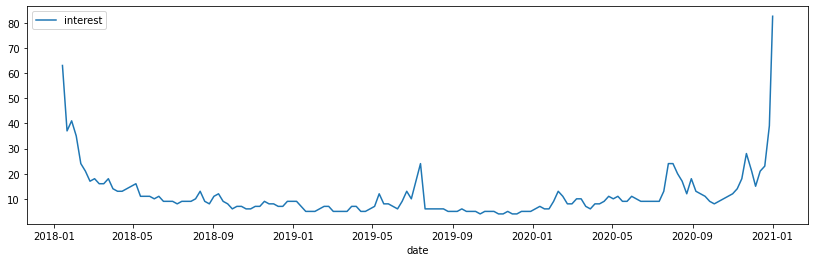

In [10]:
iot.plot(x="date", y="interest", figsize=(14,4))

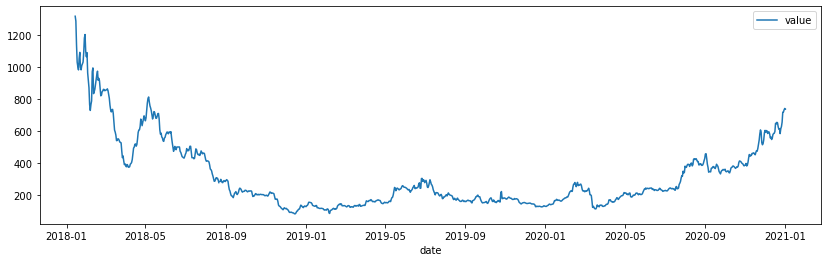

In [11]:
iot.plot(x="date", y="value", figsize=(14,4))

As we can see, both curves seem disturbingly similar. We will still need to create our model based on this and other values to see how those two curves really relate. We need to be sure it's not just the interest curve following the value curve with a one day delay for instance.

### Twint, Twitter scraping API
We first tried to use the official twitter API, but we had a lot of problems with the free token, first the time frame we were using wasn't really working for some obscure reason so the data was not on the correct dates, and we had hard calling limitations (not more than 1000 tweets at a time).

For that reason, we decided to use Twint, which is an open source API to scrape twitter that actually worked way beyong our expectations, our scraping capabilities were multiplied by at least a tenfold. 

In [ ]:
config = twint.Config()
config.Hide_output = True
config.Since = "2018-01-01"
config.Until = "2021-01-01"
config.Min_retweets = 100
config.Limit = 10000
config.Search = "Ethereum OR ETH OR #Ethereum"
config.Output = "D:/WORK/test.csv"
config.Store_csv = True

In [ ]:
twint.run.Search(c)

In [12]:
your_directory = "D:/WORK/test.csv"

df = pd.read_csv(your_directory)
df.columns

df = df[["date","tweet"]]

dates_for_trans = list(df["date"])
dates_for_trans = [date.fromisoformat(x) for x in dates_for_trans]

df["date"] = dates_for_trans

df = df[df["date"] >= date.fromisoformat("2018-01-14")]

df = df.sort_values("date")
df

,date,tweet
5338,2018-01-14,The SelfKey Token Sale sold out in 11 minutes!...
5331,2018-01-14,Komodo's BarterDEX - our decentralized (crossc...
5332,2018-01-14,Thank you @CaptainAltcoin for the awesome rati...
5333,2018-01-14,Wanchain-1.0 is finally here! We will be annou...
5337,2018-01-14,🤝Affiliate Summit West attended by more than 8...
...,...,...
9,2020-12-31,Ether $ETH is 50% off of its all-time high. It...
10,2020-12-31,#Binance will utilize the Binance #SAFU Fund...
11,2020-12-31,The price of ether $ETH right now is $735. Thi...
6,2020-12-31,I will give someone $25 in 6hrs all you have t...


Here we can see twint worked like a charm. We then needed to clean a bit the tweets to allow the sentiment analysis to be as good as possible. 

On a side note, we first thought of removing the tweets about giveaways or contests as we thought they were not important. After a few searches, we saw that they were part of the most influencal tweets because of all the comments and retweets. Finally, we decided to include those, as they seemed to still give Ethereum some online exposure

In [13]:
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing hashtags
    text = re.sub('RT[\s]+', '', text) # Removing RTs
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlinks
    
    return text.strip()
    
df["tweet"] = df["tweet"].apply(cleanTxt)
df.head()

,date,tweet
5338,2018-01-14,The SelfKey Token Sale sold out in 11 minutes!...
5331,2018-01-14,Komodo's BarterDEX - our decentralized (crossc...
5332,2018-01-14,Thank you for the awesome rating of Globitex ...
5333,2018-01-14,Wanchain-1.0 is finally here! We will be annou...
5337,2018-01-14,🤝Affiliate Summit West attended by more than 8...


We then performed sentiment analysis based on the pretrained model of the TextBlob library

In [14]:
tweets_to_analyse = list(df["tweet"])

polarity = []

for tweet in tweets_to_analyse:
    pol = TextBlob(tweet).sentiment.polarity
    if pol > 0:
        polarity.append("Positive")
    elif pol == 0:
        polarity.append("Neutral")
    else:
        polarity.append("Negative")
    
print(polarity[:5])

df["polarity"] = polarity

df.head()

['Positive', 'Neutral', 'Positive', 'Neutral', 'Positive']


,date,tweet,polarity
5338,2018-01-14,The SelfKey Token Sale sold out in 11 minutes!...,Positive
5331,2018-01-14,Komodo's BarterDEX - our decentralized (crossc...,Neutral
5332,2018-01-14,Thank you for the awesome rating of Globitex ...,Positive
5333,2018-01-14,Wanchain-1.0 is finally here! We will be annou...,Neutral
5337,2018-01-14,🤝Affiliate Summit West attended by more than 8...,Positive


## Data Preprocessing

Finally, as we had multiple tweets per day, and couldn't just use the polarity as is, we decided to add 3 columns to our original dataframe, respectively representing the positive, neutral and negative tweets with the absolute count of tweets in each category on every day. 

Turns out, we had problems dealing with a few days that have a lot more tweets than other, so instead of trying to do some kind of regularization or outlier detection, we chose to represent every class as a percentage of the total tweets. For instance, if we have 10 tweets, from which 5 are positive, our positive column will have a 0.5 value.

In [15]:
dategroups = df.groupby("date")

In [16]:
tempIndex = []
polarityDict = {"Positive":[], "Neutral":[], "Negative":[]}

for date, group in dategroups:
    if date not in tempIndex:
        tempIndex.append(date)
        polarityDict["Positive"].append(0)
        polarityDict["Neutral"].append(0)
        polarityDict["Negative"].append(0)
    
    for row_index,row in group.iterrows():
        polarityDict[row["polarity"]][-1] += 1

In [99]:
for i in range(len(polarityDict["Positive"])):
    tot = polarityDict["Positive"][i] + polarityDict["Neutral"][i] + polarityDict["Negative"][i]
    
    if tot != 0:
        polarityDict["Positive"][i] = polarityDict["Positive"][i]/tot
        polarityDict["Neutral"][i] = polarityDict["Neutral"][i]/tot
        polarityDict["Negative"][i] = polarityDict["Negative"][i]/tot
    else:
        polarityDict["Positive"][i] = 0
        polarityDict["Neutral"][i] = 0
        polarityDict["Negative"][i] = 0
        
polarity_df = pd.DataFrame.from_dict(polarityDict)
polarity_df.index = tempIndex

polarity_df.head()

,Positive,Neutral,Negative
2018-01-14,0.500000,0.375000,0.125000
2018-01-15,0.666667,0.083333,0.250000
2018-01-16,0.562500,0.375000,0.062500
2018-01-17,0.250000,0.750000,0.000000
2018-01-18,0.333333,0.500000,0.166667


In [100]:
joined_df_value_and_polarity = iot.join(polarity_df)
joined_df_value_and_polarity.head()

,date,interest,value,Positive,Neutral,Negative
date,,,,,,
2018-01-14,2018-01-14,63.000000,1318.670,0.500000,0.375000,0.125000
2018-01-15,2018-01-15,59.285714,1288.495,0.666667,0.083333,0.250000
2018-01-16,2018-01-16,55.571429,1139.415,0.562500,0.375000,0.062500
2018-01-17,2018-01-17,51.857143,1031.390,0.250000,0.750000,0.000000
2018-01-18,2018-01-18,48.142857,1003.315,0.333333,0.500000,0.166667


We don't scale based on min and max, but by the all time high of ethereum to keep the scale intact between training and testing. This will give better results, but will be unable to respond well to values outside of (0,max(Eth)), which means a new model would need to be trained every time the maximum is reached

In [102]:
production_df = joined_df_value_and_polarity.drop(["date"], axis=1)
production_df["interest"] = production_df["interest"]/100

production_df["value"] = production_df["value"]/1500 

# We have a few NaN values, for the days where we didn't have any tweets, for that matter, we replace them with 0s
production_df = production_df.fillna(0)
#production_df.to_csv("prodFinance.csv")
production_df.head(6)

,interest,value,Positive,Neutral,Negative
date,,,,,
2018-01-14,0.630000,0.879113,0.500000,0.375000,0.125000
2018-01-15,0.592857,0.858997,0.666667,0.083333,0.250000
2018-01-16,0.555714,0.759610,0.562500,0.375000,0.062500
2018-01-17,0.518571,0.687593,0.250000,0.750000,0.000000
2018-01-18,0.481429,0.668877,0.333333,0.500000,0.166667
2018-01-19,0.444286,0.655477,0.833333,0.166667,0.000000


## Model Construction

In [103]:
print("shape : ", production_df.shape)

shape :  (1084, 5)


As we are studying time series, we create a dataset where every point has reference to the last two points (essentially, looking at a day and the last two days before it)

In [104]:
batch_size = 1
epochs = 8
lookback = 3

def create_dataset(dataset, lookback=3):
    dataX, dataY = [],[]
    for i in range(len(dataset)-lookback-1):
        a = dataset[i:(i+lookback), :]
        dataX.append(a)
        dataY.append(dataset[i + lookback, 1])
        
    return np.array(dataX), np.array(dataY)

Now that our data is correctly formated, we split it between training and testing data. For that matter, we use 2/3 of our data for training and 0.5 for testing.

In [105]:
dataset = production_df.values

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

dataset[:5]

726 358


array([[0.63      , 0.87911333, 0.5       , 0.375     , 0.125     ],
       [0.59285714, 0.85899667, 0.66666667, 0.08333333, 0.25      ],
       [0.55571429, 0.75961   , 0.5625    , 0.375     , 0.0625    ],
       [0.51857143, 0.68759333, 0.25      , 0.75      , 0.        ],
       [0.48142857, 0.66887667, 0.33333333, 0.5       , 0.16666667]])

In [106]:
trainX, trainY = create_dataset(train) # default to lookback=3
testX, testY = create_dataset(test)

Now, our data has the correct (nb_of_samples, lookback, number_of_columns) format

In [108]:
trainX.shape

(722, 3, 5)

In [188]:
trainX[:2]

array([[[0.63      , 0.87911333, 0.5       , 0.375     , 0.125     ],
        [0.59285714, 0.85899667, 0.66666667, 0.08333333, 0.25      ],
        [0.55571429, 0.75961   , 0.5625    , 0.375     , 0.0625    ]],

       [[0.59285714, 0.85899667, 0.66666667, 0.08333333, 0.25      ],
        [0.55571429, 0.75961   , 0.5625    , 0.375     , 0.0625    ],
        [0.51857143, 0.68759333, 0.25      , 0.75      , 0.        ]]])

In [187]:
trainY[:2]

array([0.68759333, 0.66887667])

## Sanity Check

In [113]:
# Sanity check before sending data to model
print(np.any(np.isnan(trainX)))
print(np.any(np.isnan(trainY)))
print(np.any(np.isnan(testX)))
print(np.any(np.isnan(testY)))

False
False
False
False


In [167]:
lstm_model = Sequential()

lstm_model.add(Dense(15, input_shape=(3, 5)))
lstm_model.add(LSTM(15, dropout = 0.3, recurrent_dropout = 0.3, go_backwards = True))
lstm_model.add(Dense(15))
lstm_model.add(Dense(15))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')

## Model Training
We train our model for 32 epochs, that epochs after that don't really lower the loss anymore, we use 10% of the data for validation, and we use a small batch_size as we don't have a lot of data.

In [168]:
history = lstm_model.fit(trainX, trainY, epochs=32, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/32
21/21 [==============================] - 2s 17ms/step - loss: 0.0364 - val_loss: 0.0068
Epoch 2/32
21/21 [==============================] - 0s 4ms/step - loss: 0.0151 - val_loss: 0.0027
Epoch 3/32
21/21 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 7.3431e-04
Epoch 4/32
21/21 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 1.6951e-04
Epoch 5/32
21/21 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 1.1081e-04
Epoch 6/32
21/21 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 1.6027e-04
Epoch 7/32
21/21 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 6.8235e-05
Epoch 8/32
21/21 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 3.4253e-05
Epoch 9/32
21/21 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 2.0123e-04
Epoch 10/32
21/21 [==============================] - 0s 4ms/step - loss: 0.0026 - val_los

## Evaluation

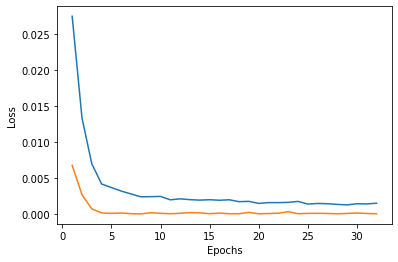

In [169]:
plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']
x_values = range(1, len(loss)+1)

plt.plot(x_values, loss) # blue
plt.plot(x_values, val_loss) # orange

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Here we plot the training and validation loss over the epochs, we can see it drops very fast and doesn't go back up on validation thanks to the adam optimizer, and the dropout we added inside the model.

In [184]:
training_preds = lstm_model.predict(trainX)
preds = lstm_model.predict(testX)

print("RMSE for training")
print(np.sqrt(mean_squared_error(trainY, training_preds)))

print("\nRMSE for testing")
print(np.sqrt(mean_squared_error(testY, preds)))

RMSE for training
0.021962961313557548

RMSE for testing
0.013521656873679358


As we scaled our target, we can see the RMSE as a percentage error on our regression prediction, having 1.3% error on average on testing seem very good for our problem !

In [186]:
delta = [np.sqrt(testY[i]) - np.sqrt(preds[i][0]) for i in range(len(preds))]
delta = [(testY[i]) - (preds[i][0]) for i in range(len(preds))]

print("we calculate the difference between our target variable and the predicted value")
print("head: ", delta[:5])

print("\nvariance of our delta, (lower is better)")
print(np.var(delta))

we calculate the difference between our target variable and the predicted value
head:  [-0.0038943951272964322, 0.0035877316355705097, 0.002737742686271666, 0.0034689832917849245, -0.00231526723543804]

variance of our delta, (lower is better)
0.00018225916550657293


We just calculated the variance to make sure we didn't have some very high deviation, and it seems that our model is viable enough.

However, this result is to take with a grain of salt, the output of this model and it's applicability should be tested over an extensive period of time before using this as an actual trading tool. In the mean time, from what we can see, we have a very good result that would necessitate more work to become more robust, but we are very happy about how it turned out.




Authors :
* *Quentin Tourette*
* *Victor Larrezet*